In [5]:
import torch
import glob, yaml, os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 100
from PIL import Image

from ddpm.model import Diffusion_UNet
from ddpm.diffusion import DDIM_Sampler

## load model

(4, 256, 256)
Process: image_1


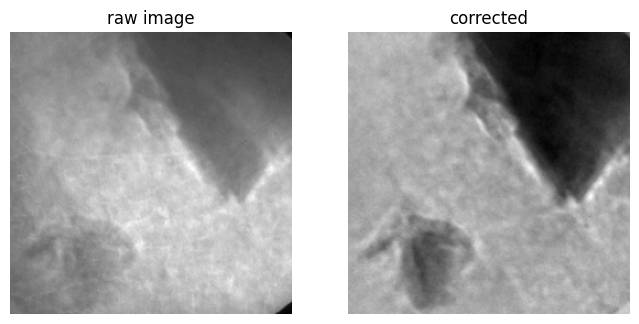

Process: image_2


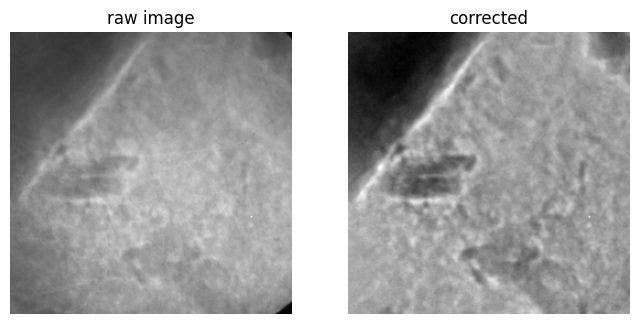

Process: image_3


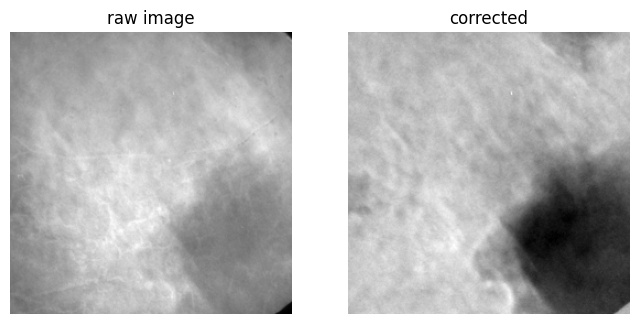

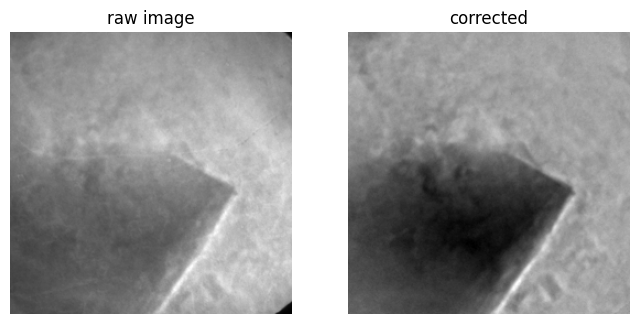

In [ ]:
config_path = 'configs/ddpm_pair_v2.yml'
model_path = 'checkpoints/ddpm_pair_v3_400K.pt'
data_folder = 'demo_imgs/20230222_Sb_m6-1-b2-60s-0.88V'

with open(config_path, 'r') as f:
    configs = yaml.safe_load(f)
model_configs = configs['model_settings']
ddpm_configs = configs['ddpm_settings']
img_size = configs['data_settings']['img_size']

model = Diffusion_UNet(model_configs).cuda()
model = torch.nn.DataParallel(model)
model.load_state_dict(torch.load(model_path, map_location='cuda:0'), strict=False)
model.eval()
sampler = DDIM_Sampler(model, ddpm_configs, ddim_sampling_steps=50).cuda()

# load images
img_list = sorted(glob.glob(f'{data_folder}/*.tif'))
imgs = []
for img_path in img_list:
    img_path = os.path.normpath(img_path)
    im = Image.open(img_path).resize((img_size, img_size))
    imgs.append(np.array(im))
imgs = np.array(imgs)
global_max_g = np.max(imgs)
print(imgs.shape)

# inference
dref_imgs = []
os.makedirs('figs', exist_ok=True)
with torch.no_grad():
    for i in range(len(imgs)-1):
        print(f'Process: image_{i+1}')
        max_g = max(np.max(imgs[i]), np.max(imgs[i+1]))
        input_1 = torch.from_numpy(imgs[i]/max_g).unsqueeze(0).float()
        input_2 = torch.from_numpy(imgs[i+1]/max_g).unsqueeze(0).float()
        input_imgs = torch.cat([input_1, input_2], dim=0)
        torch.manual_seed(1)
        noise = torch.randn(size=[1, 1, img_size, img_size]).cuda()
        pred = sampler(input_imgs.view(1, 2, img_size, img_size).cuda(), noise).squeeze().cpu().numpy()
        obj_pred_1 = imgs[i]/pred/global_max_g
        obj_pred_2 = imgs[i+1]/pred/global_max_g
        obj_pred_1 = np.clip(obj_pred_1, obj_pred_1[:, :-30].min(), obj_pred_1[:, :-30].max())
        obj_pred_2 = np.clip(obj_pred_2, obj_pred_2[:, :-30].min(), obj_pred_2[:, :-30].max())
        fig, ax = plt.subplots(1, 2, figsize=(8, 4))
        ax[0].imshow(imgs[i], cmap='gray')
        ax[1].imshow(obj_pred_1, cmap='gray')
        ax[0].axis('off')
        ax[1].axis('off')
        ax[0].set_title('raw image')
        ax[1].set_title('corrected')
        plt.show()
        plt.close()
        im = Image.fromarray(obj_pred_1)

        if i == len(imgs)-2:
            fig, ax = plt.subplots(1, 2, figsize=(8, 4))
            ax[0].imshow(imgs[i+1], cmap='gray')
            ax[1].imshow(obj_pred_2, cmap='gray')
            ax[0].axis('off')
            ax[1].axis('off')
            ax[0].set_title('raw image')
            ax[1].set_title('corrected')
            plt.show()
            plt.close()
            im = Image.fromarray(obj_pred_2)